<h1>WineRanks: Sip, Savor, and Predict pt 2</h1>

Lab Five: Wide and Deep Networks

Emily Liss

<H1>Business Understanding</H1>

Wine producers and marketers often strive to create wines that cater to the diverse preferences of consumers. Predicting the quality of wine based on its chemical properties can help wineries improve production processes, target the right market segments, and make informed decisions regarding pricing and marketing strategies. This dataset aims to leverage a machine learning model to predict wine quality and assist wineries in enhancing their wine production and marketing efforts. The set includes data for each wine tested's: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, quality (on a scale from 1-10), and Id. With this data, wineries can ensure consistent wine quality, reducing the risk of producing subpar wines and enhancing brand reputation. This model would most likely be used offline for research purposes, historical analysis, or batch processing where wine quality assessment isn't time-sensitive. We would need to compare the model predictions against expert sommeliers' opinions to determine a benchmark on how useful the model is.

Dataset Source: https://www.kaggle.com/datasets/naliniajwani/wine-quality-prediction-dataset

<H2>Load Data</H2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

#Read in the dataset
ds = pd.read_csv('C:/Users/emily/Downloads/WineArchive/WineQuality.csv')
#clean data, remove empty cells
ds = ds.drop(columns=['Id'])
ds = ds.dropna()
ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<h2>Prepare Data</h2>

In [2]:
from sklearn.preprocessing import StandardScaler

# Feature engineering - cross-product of acidity-related features
ds['acidity_interaction'] = ds['fixed acidity'] * ds['volatile acidity'] * ds['citric acid']
X = ds.drop('quality', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#define any wine with a quiality of 6 or higher as good
ds['good_or_bad'] = (ds['quality'] >= 6).astype(int)
y = ds['good_or_bad']

The final data set uses most of the original features of the wine composition (acidity, residual sugar, chlorides, sulfur dioxide, density, pH, sulphates, alcohol) and the new variable, "acidity_interaction", showing the cross-product of the acidity-related features (fixed acidity, volatile acidity, citric acid). This new variable should show potential interactions between these acidity components, which might have an impact on the wine quality classification. The target variable "good_or_bad" distinguishes between wines rated as 'good' (quality >= 6) and 'bad' (quality < 6).

<h2>Acidity vs Quality</h2>

We've made a new variable "acidity_interaction", let's see if there's any correlation to the wine quality

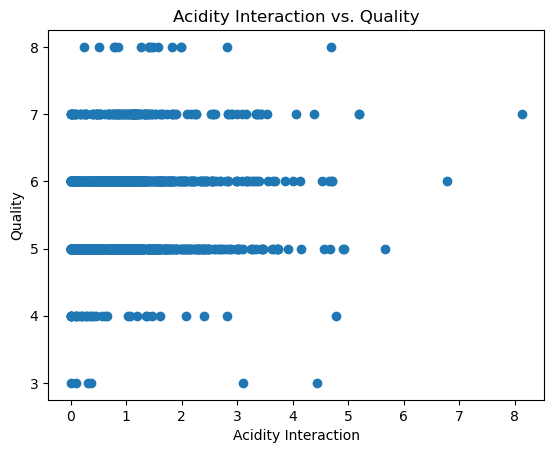

Correlation between acidity_interaction and quality: 0.07863915157742117


In [3]:
import matplotlib.pyplot as plt

plt.scatter(ds['acidity_interaction'], ds['quality'])
plt.xlabel('Acidity Interaction')
plt.ylabel('Quality')
plt.title('Acidity Interaction vs. Quality')
plt.show()
correlation = ds['acidity_interaction'].corr(ds['quality'])
print(f"Correlation between acidity_interaction and quality: {correlation}")

It doesn't look like there's much correlation

<h2>Pairplot showing how different aspects relate to the quality of the wine</h2>

I've removed the columns with the smallest standard diviation for this model to show factors that would have more correlation to the wine quality

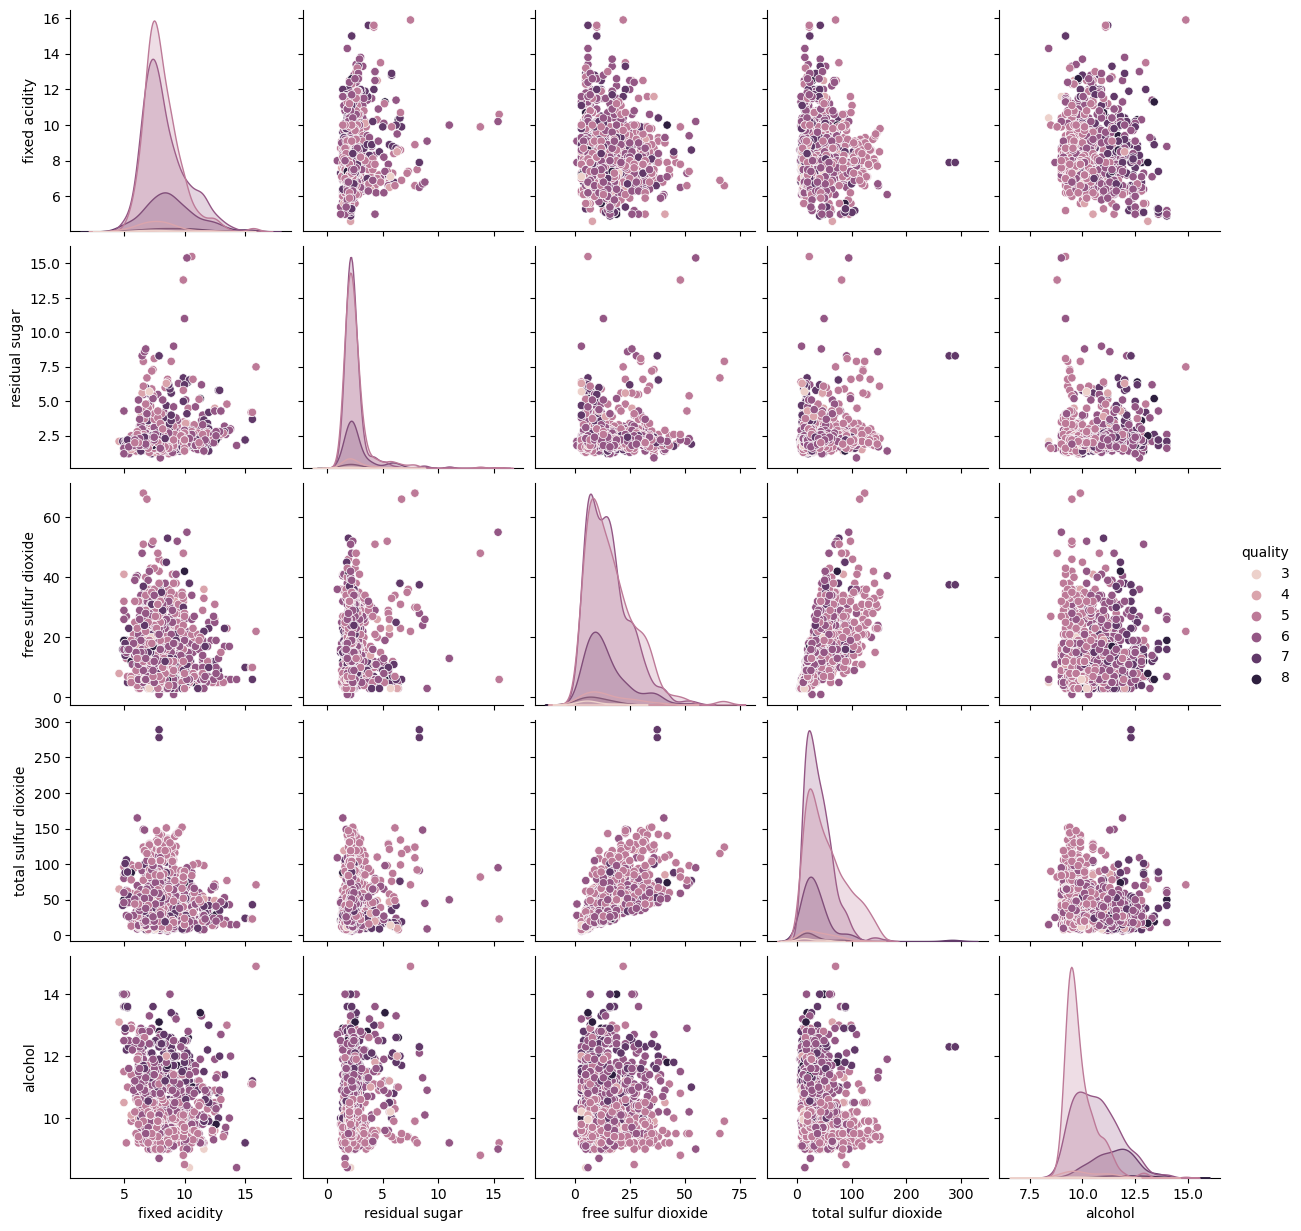

In [4]:
sns.pairplot(ds, vars=['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'], hue='quality')
plt.show()

<h2>Wide and Deep</h2>

Make the custom wide and deep function

In [22]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import Model
def wide_and_deep(layers_deep, X):
    input_layer = Input(shape=(X.shape[1],))
    
    # Wide branch
    wide = Dense(32, activation='relu')(input_layer)
    
    # Deep branch
    deep = Dense(64, activation='relu')(input_layer)
    for _ in range(layers_deep - 1):
        deep = Dense(64, activation='relu')(deep)
    
    # Concatenating wide and deep branches
    combined = Concatenate()([wide, deep])
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
    
    return model

<h2>Let's Try it With 2, 4, and 6 Layers</h2>

When dividing the data into training and testing, I'm using Stratified K-Fold Cross-Validation. It ensures that each fold maintains the same proportion of 'good' and 'bad' quality wines as the overall dataset. This method helps in mitigating biases and provides a more robust evaluation of the models' performance, especially considering the potential class imbalance in the dataset. It also mirrors real-world scenarios better by ensuring that the algorithm trains on a diverse representation of both 'good' and 'bad' quality wines in various folds, enhancing the generalization capability of the models.

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_2_layers = wide_and_deep(2, X_train)
    model_4_layers = wide_and_deep(4, X_train)
    model_6_layers = wide_and_deep(6, X_train)

# Train the models
history_2_layers = model_2_layers.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
yhat = np.round(model_2_layers.predict(X_test))
print("Wide and Deep with 2 Layers")
print(mt.classification_report(y_test,yhat))

history_4_layers = model_4_layers.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
yhat = np.round(model_4_layers.predict(X_test))
print("Wide and Deep with 4 Layers")
print(mt.classification_report(y_test,yhat))

history_6_layers = model_6_layers.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
yhat = np.round(model_6_layers.predict(X_test))
print("Wide and Deep with 6 Layers")
print(mt.classification_report(y_test,yhat))

4/4 [==============================] - 0s 2ms/step
Wide and Deep with 2 Layers
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        52
           1       0.81      0.77      0.79        62

    accuracy                           0.78       114
   macro avg       0.78      0.78      0.78       114
weighted avg       0.78      0.78      0.78       114

4/4 [==============================] - 0s 2ms/step
Wide and Deep with 4 Layers
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        52
           1       0.77      0.82      0.80        62

    accuracy                           0.77       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.77      0.77      0.77       114

4/4 [==============================] - 0s 2ms/step
Wide and Deep with 6 Layers
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        52


In [46]:
metrics_2_layers = {'accuracy': history_2_layers.history['accuracy'], 'precision': history_2_layers.history['precision'], 'recall': history_2_layers.history['recall'], 'auc': history_2_layers.history['auc']}
metrics_4_layers = {'accuracy': history_4_layers.history['accuracy'], 'precision': history_4_layers.history['precision'], 'recall': history_4_layers.history['recall'], 'auc': history_4_layers.history['auc']}
metrics_6_layers = {'accuracy': history_6_layers.history['accuracy'], 'precision': history_6_layers.history['precision'], 'recall': history_6_layers.history['recall'], 'auc': history_6_layers.history['auc']}
x = 2
for layer in [metrics_2_layers, metrics_4_layers, metrics_6_layers]:
    print(f'{x} Deep Layers:')
    for metric in ['accuracy', 'precision', 'recall', 'auc']:
        ave_metric = sum(layer[metric]) / len(layer[metric])
        print(f'Average {metric} across 10 folds: {ave_metric* 100:.2f}%')
    x = x + 2
    print()

2 Deep Layers:
Average accuracy across 10 folds: 80.07%
Average precision across 10 folds: 82.24%
Average recall across 10 folds: 80.72%
Average auc across 10 folds: 88.45%

4 Deep Layers:
Average accuracy across 10 folds: 87.08%
Average precision across 10 folds: 87.93%
Average recall across 10 folds: 88.30%
Average auc across 10 folds: 93.16%

6 Deep Layers:
Average accuracy across 10 folds: 89.30%
Average precision across 10 folds: 89.31%
Average recall across 10 folds: 91.20%
Average auc across 10 folds: 94.58%



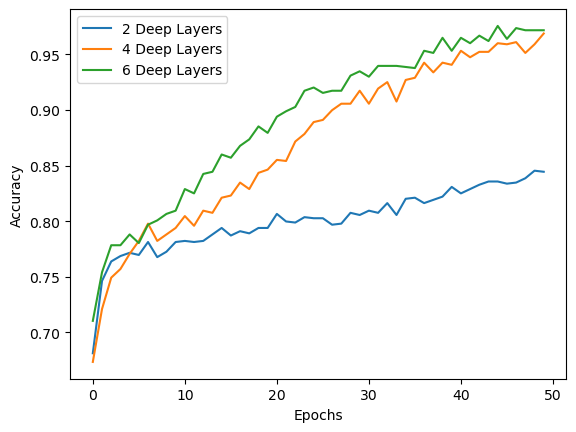

In [47]:
# Plot performance for different number of deep layers
plt.plot(history_2_layers.history['accuracy'], label='2 Deep Layers')
plt.plot(history_4_layers.history['accuracy'], label='4 Deep Layers')
plt.plot(history_6_layers.history['accuracy'], label='6 Deep Layers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h2>Let's look at Them Separately</h2>

To evaluate the performance of a binary classification setting, the choice of metrics should go beyond accuracy due to potential imbalances in the class distribution. In this context, precision, recall, and AUC score become significant. Precision calculates the ratio of correctly predicted positive observations to the total predicted positive observations, recall computes the ratio of correctly predicted positive observations to the all observations in actual class, while AUC score shows the true positive to false positive ratio. So we'll be looking at all of these metrics to evaluate the model.

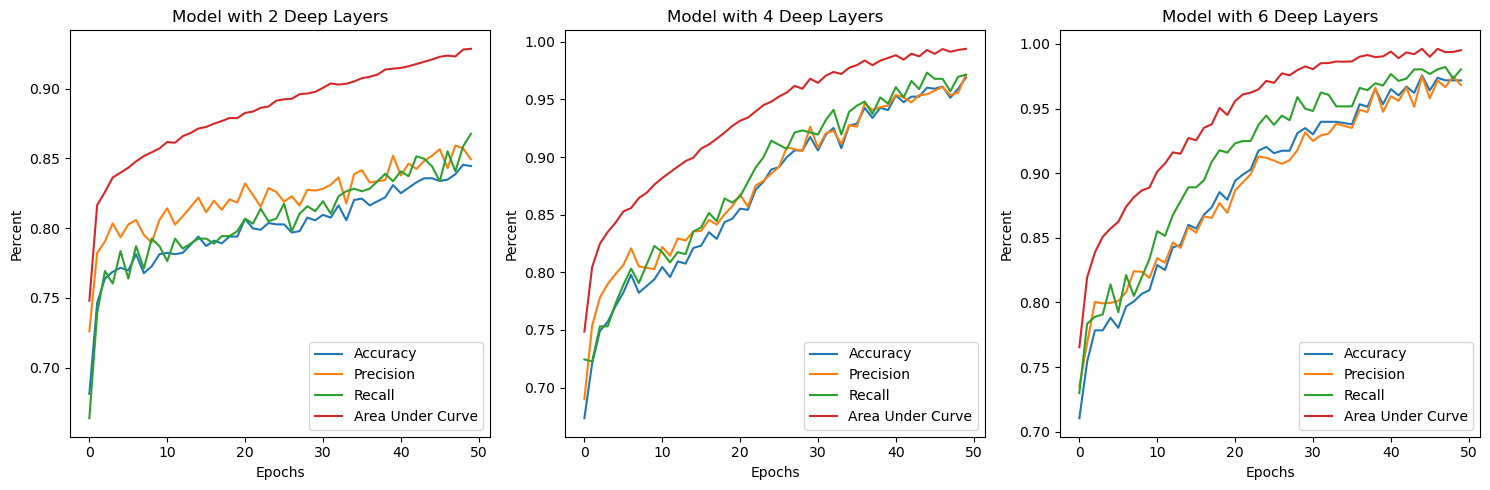

In [48]:
plt.figure(figsize=(15, 5))

# Plot for model with 2 deep layers
plt.subplot(1, 3, 1)
plt.plot(history_2_layers.history['accuracy'], label='Accuracy')
plt.plot(history_2_layers.history['precision'], label='Precision')
plt.plot(history_2_layers.history['recall'], label='Recall')
plt.plot(history_2_layers.history['auc'], label='Area Under Curve')
plt.title('Model with 2 Deep Layers')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend()

# Plot for model with 4 deep layers
plt.subplot(1, 3, 2)
plt.plot(history_4_layers.history['accuracy'], label='Accuracy')
plt.plot(history_4_layers.history['precision'], label='Precision')
plt.plot(history_4_layers.history['recall'], label='Recall')
plt.plot(history_4_layers.history['auc'], label='Area Under Curve')
plt.title('Model with 4 Deep Layers')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend()

# Plot for model with 6 deep layers
plt.subplot(1, 3, 3)
plt.plot(history_6_layers.history['accuracy'], label='Accuracy')
plt.plot(history_6_layers.history['precision'], label='Precision')
plt.plot(history_6_layers.history['recall'], label='Recall')
plt.plot(history_6_layers.history['auc'], label='Area Under Curve')
plt.title('Model with 6 Deep Layers')
plt.xlabel('Epochs')
plt.ylabel('Percent')
plt.legend()

plt.tight_layout()
plt.show()

<h2>Layers Metrics</h2>

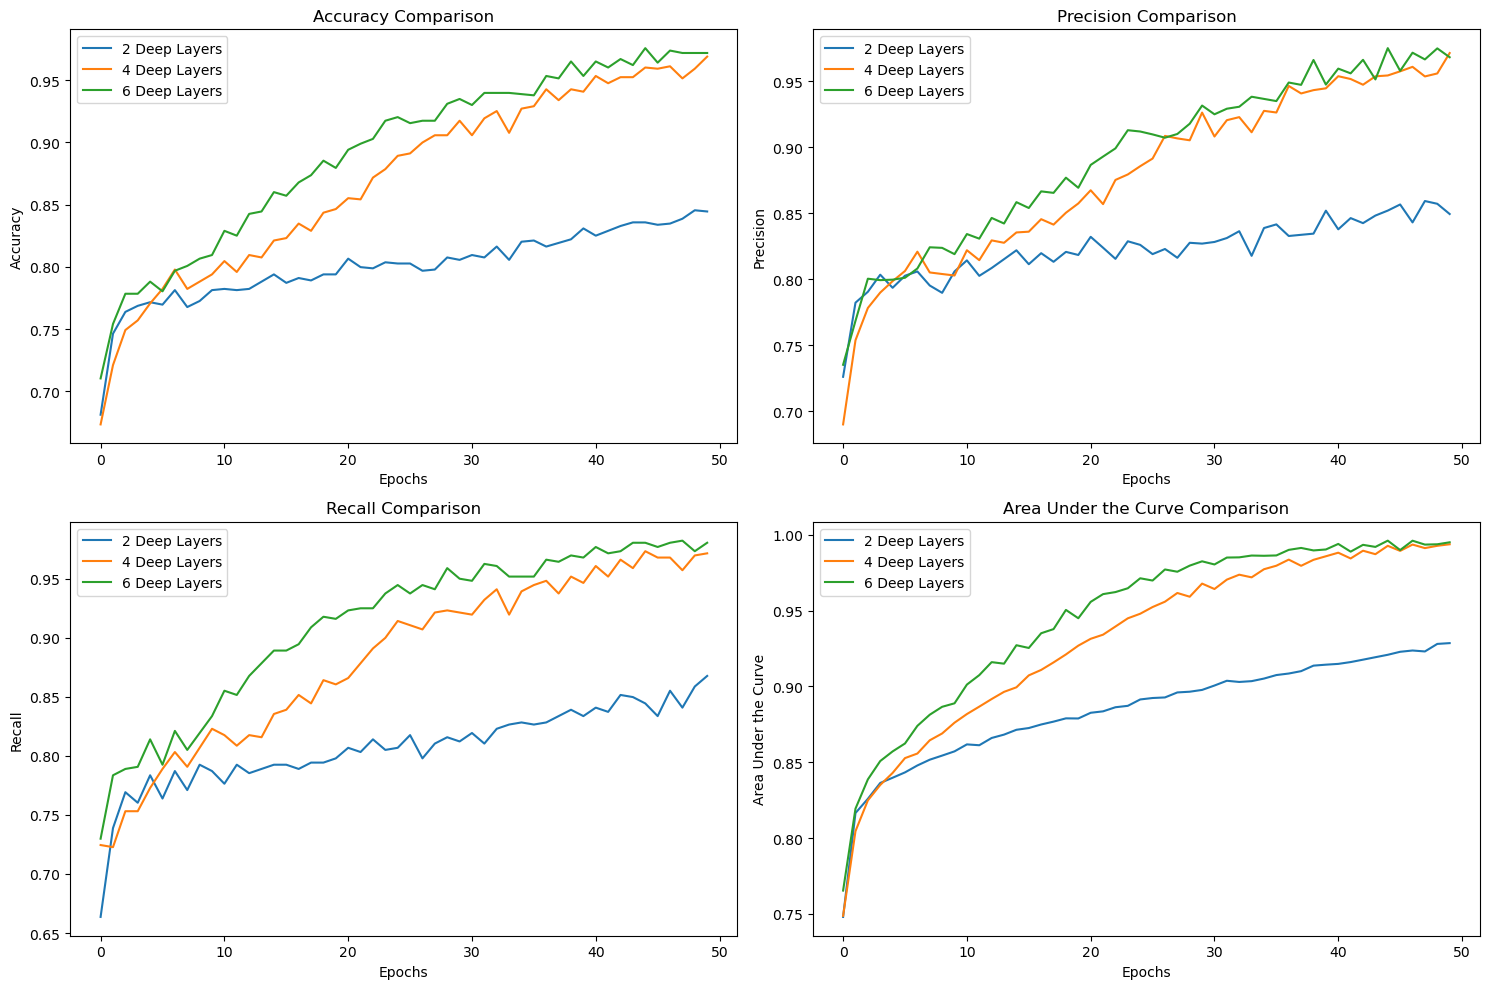

In [49]:
metrics = ['Accuracy', 'Precision', 'Recall', 'Area Under the Curve']
values_2_layers = [history_2_layers.history['accuracy'], history_2_layers.history['precision'], history_2_layers.history['recall'], history_2_layers.history['auc']]
values_4_layers = [history_4_layers.history['accuracy'], history_4_layers.history['precision'], history_4_layers.history['recall'], history_4_layers.history['auc']]
values_6_layers = [history_6_layers.history['accuracy'], history_6_layers.history['precision'], history_6_layers.history['recall'], history_6_layers.history['auc']]

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(values_2_layers[i], label='2 Deep Layers')
    plt.plot(values_4_layers[i], label='4 Deep Layers')
    plt.plot(values_6_layers[i], label='6 Deep Layers')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

The 6 layer network performs better across every metric we're looking at! I also tested with 8 and even 10 layers, but the results stagnated or dropped after 6 layers.

<h2>Multi-Layer Perceptron!</h2>

In [50]:
from tensorflow.keras.models import Sequential
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(1, activation='sigmoid'))

mlp_model.compile(loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
history_mlp = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate and compare the best wide and deep network with the MLP
yhat_wide_and_deep = np.round(model_6_layers.predict(X_test))
yhat_mlp = np.round(mlp_model.predict(X_test))

print("Wide and Deep with 4 Deep Layers")
print(mt.classification_report(y_test, yhat_wide_and_deep))

print("MLP")
print(mt.classification_report(y_test, yhat_mlp))

4/4 [==============================] - 0s 3ms/step
Wide and Deep with 4 Deep Layers
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        52
           1       0.82      0.73      0.77        62

    accuracy                           0.76       114
   macro avg       0.77      0.77      0.76       114
weighted avg       0.77      0.76      0.76       114

MLP
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        52
           1       0.76      0.85      0.80        62

    accuracy                           0.77       114
   macro avg       0.78      0.76      0.77       114
weighted avg       0.77      0.77      0.77       114



In [51]:
values_mlp = {'accuracy': history_mlp.history['accuracy'], 'precision': history_mlp.history['precision'], 'recall': history_mlp.history['recall'], 'auc': history_mlp.history['auc']}

print('6 Deep Layers:')
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    ave_metric = sum(metrics_6_layers[metric]) / len(metrics_6_layers[metric])
    print(f'Average {metric}: {ave_metric* 100:.2f}%')

print('\nMLP:')
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    ave_metric = sum(values_mlp[metric]) / len(values_mlp[metric])
    print(f'Average {metric}: {ave_metric* 100:.2f}%')

6 Deep Layers:
Average accuracy: 89.30%
Average precision: 89.31%
Average recall: 91.20%
Average auc: 94.58%

MLP:
Average accuracy: 81.09%
Average precision: 82.92%
Average recall: 82.10%
Average auc: 89.11%


<h2>Let's Compare the 6 Deep Layers and the Multi-Layer Perceptron!</h2> 

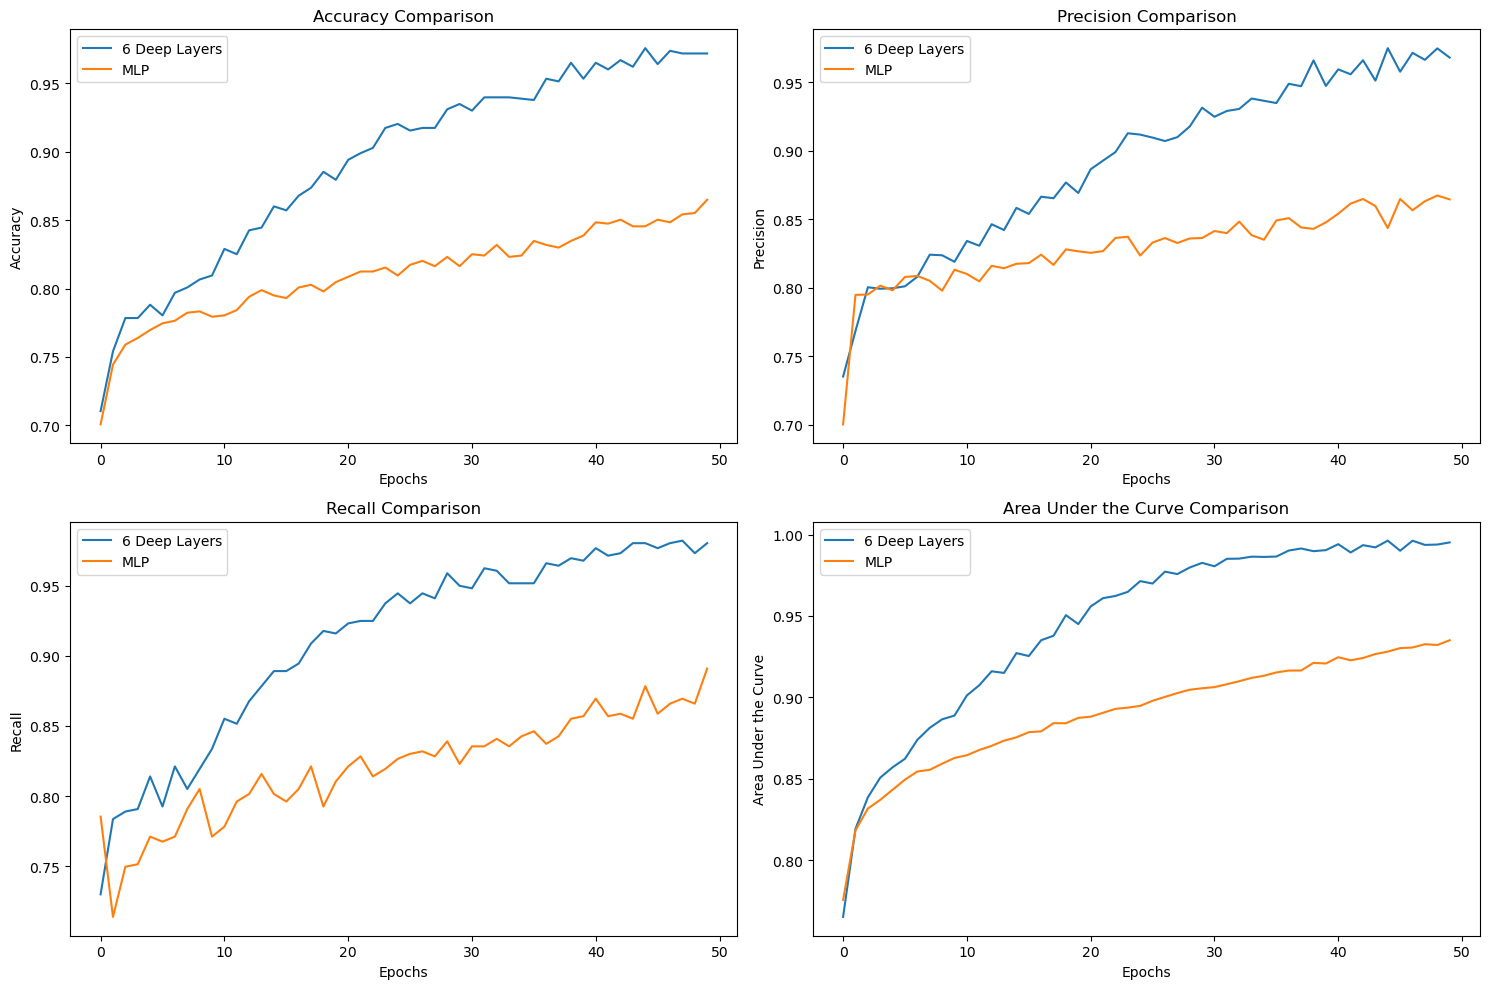

In [52]:
values_mlp = [history_mlp.history['accuracy'], history_mlp.history['precision'], history_mlp.history['recall'], history_mlp.history['auc']]
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(values_6_layers[i], label='6 Deep Layers')
    plt.plot(values_mlp[i], label='MLP')
    plt.title(f'{metric} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

Once again the 6 layer network is performing better in every metric we're using to compare! 